In [1]:
import pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('proj').getOrCreate()

24/04/08 16:32:27 WARN Utils: Your hostname, Apples-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 172.20.10.2 instead (on interface en0)
24/04/08 16:32:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/08 16:32:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark.sparkContext.getConf().getAll()

[('spark.app.submitTime', '1712574147871'),
 ('spark.app.id', 'local-1712574148917'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.app.star

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, StandardScaler, MinHashLSH, VectorAssembler
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.stat import KernelDensity

In [5]:
email = spark.read.csv( '/Users/apple/Desktop/email.csv',inferSchema=True,header=True)

In [6]:
email.printSchema()
email.show(5)

root
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- user: string (nullable = true)
 |-- pc: string (nullable = true)
 |-- to: string (nullable = true)
 |-- cc: string (nullable = true)
 |-- bcc: string (nullable = true)
 |-- from: string (nullable = true)
 |-- size: integer (nullable = true)
 |-- attachments: integer (nullable = true)
 |-- content: string (nullable = true)

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338

In [7]:
tokenizer = Tokenizer(inputCol="content", outputCol="words")
wordsData = tokenizer.transform(email)

remover = StopWordsRemover(inputCol="words", outputCol="clean_words")
wordsData = remover.transform(wordsData)

In [8]:
wordsData.show()

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|               words|         clean_words|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338|PC-5758|Dean.Flynn.Hines@...|Nathaniel.Hunter....|                NULL|Lynn.Adena.Pratt@...|25830|          0|middle f2 systems...|[middle, f2, syst...|[middle, f2, syst...|
|{R0R9-E4GL59IK-29...|01/02/2010 07:12:16|MOH0273|PC-6699|Odonnell-Gage@bel...|                NULL|    

In [9]:
cv = CountVectorizer(inputCol="clean_words", outputCol="features", vocabSize=1000, minDF=2.0)

model = cv.fit(wordsData)

wordsCV = model.transform(wordsData)

24/04/08 16:32:42 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [10]:
all0vector = Vectors.dense([0]*1000) 

def no_empty_vector(value):
    if value != all0vector:
        return True
    else:
        return False

no_empty_vector_udf = udf(no_empty_vector, BooleanType())
wordsCV = wordsCV.filter(no_empty_vector_udf('features'))

In [11]:
wordsCV.show()

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|               words|         clean_words|            features|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338|PC-5758|Dean.Flynn.Hines@...|Nathaniel.Hunter....|                NULL|Lynn.Adena.Pratt@...|25830|          0|middle f2 systems...|[middle, f2, syst...|[middle, f2, syst...|(1000,[28,59,105,...|
|{R0R9-E4GL59IK-29..

In [12]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=20)
model = mh.fit(wordsCV)
wordsHash = model.transform(wordsCV)

In [13]:
wordsHash.show()

+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                  id|               date|   user|     pc|                  to|                  cc|                 bcc|                from| size|attachments|             content|               words|         clean_words|            features|              hashes|
+--------------------+-------------------+-------+-------+--------------------+--------------------+--------------------+--------------------+-----+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|01/02/2010 07:11:45|LAP0338|PC-5758|Dean.Flynn.Hines@...|Nathaniel.Hunter....|                NULL|Lynn.Adena.Pratt@...|25830|          0|middle f2 systems...|[middle, f2, syst...|

In [14]:
id_hash = wordsHash.select('id', 'hashes')

In [15]:
sc = spark.sparkContext

numAttrs = 20
attrs = sc.parallelize(["hash_" + str(i) for i in range(numAttrs)]).zipWithIndex().collect()
for name, index in attrs:
    id_hash = id_hash.withColumn(name, id_hash['hashes'].getItem(index))

In [16]:
id_hash.show()

+--------------------+--------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+
|                  id|              hashes|        hash_0|        hash_1|        hash_2|        hash_3|        hash_4|        hash_5|        hash_6|        hash_7|        hash_8|        hash_9|       hash_10|       hash_11|       hash_12|       hash_13|       hash_14|       hash_15|       hash_16|       hash_17|       hash_18|       hash_19|
+--------------------+--------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------

In [17]:
udf_getNumber = udf(lambda x: int(x[0]), LongType())

for col_num in range(20):
    id_hash = id_hash.withColumn('hash_'+str(col_num), udf_getNumber('hash_'+str(col_num)))

In [18]:
id_hash.show()

+--------------------+--------------------+---------+---------+---------+---------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|                  id|              hashes|   hash_0|   hash_1|   hash_2|   hash_3|    hash_4|   hash_5|   hash_6|   hash_7|   hash_8|   hash_9|  hash_10|  hash_11|  hash_12|  hash_13|  hash_14|  hash_15|  hash_16|  hash_17|  hash_18|  hash_19|
+--------------------+--------------------+---------+---------+---------+---------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+
|{R3I7-S4TX96FG-82...|[[2.7410964E7], [...| 27410964|  1656422| 54649098| 63318234|  91997456|146204045|  6906386| 16189098| 86948313|131602957| 35571356|204248289| 49109483| 97405986| 25666611|201316840|172511998|  1260398| 49844120|  2140447|
|{R0R9-E4GL59IK-29..

In [19]:
hash_cols = ['hash_'+str(i) for i in range(20)]

assembler = VectorAssembler(inputCols=hash_cols, outputCol="features")
id_hash = assembler.transform(id_hash)

In [20]:
id_hash.show()

24/04/08 16:33:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+---------+---------+---------+---------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+
|                  id|              hashes|   hash_0|   hash_1|   hash_2|   hash_3|    hash_4|   hash_5|   hash_6|   hash_7|   hash_8|   hash_9|  hash_10|  hash_11|  hash_12|  hash_13|  hash_14|  hash_15|  hash_16|  hash_17|  hash_18|  hash_19|            features|
+--------------------+--------------------+---------+---------+---------+---------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+
|{R3I7-S4TX96FG-82...|[[2.7410964E7], [...| 27410964|  1656422| 54649098| 63318234|  91997456|146204045|  6906386| 16189098| 86948313|131602957| 35571356|204248289| 49109483| 97405986| 25666611|20131684

In [21]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler 
scalerModel = scaler.fit(id_hash)

# Normalize each feature to have unit standard deviation. 
id_hash_scaled = scalerModel.transform(id_hash)
id_hash_scaled.show()

+--------------------+--------------------+---------+---------+---------+---------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+
|                  id|              hashes|   hash_0|   hash_1|   hash_2|   hash_3|    hash_4|   hash_5|   hash_6|   hash_7|   hash_8|   hash_9|  hash_10|  hash_11|  hash_12|  hash_13|  hash_14|  hash_15|  hash_16|  hash_17|  hash_18|  hash_19|            features|      scaledFeatures|
+--------------------+--------------------+---------+---------+---------+---------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|[[2.7410964E7], [...| 27410964|  1656422| 54649098| 63318234|  91997456|146204045|  6906386| 16189098| 86948313|13160

In [22]:
id_hash_scaled = id_hash_scaled.select('id','scaledFeatures')
id_hash_scaled.show()

+--------------------+--------------------+
|                  id|      scaledFeatures|
+--------------------+--------------------+
|{R3I7-S4TX96FG-82...|[0.17826141963802...|
|{R0R9-E4GL59IK-29...|[0.66223787509691...|
|{G2B2-A8XY58CP-28...|[2.66936050550442...|
|{A3A9-F4TH89AA-83...|[1.77243634755169...|
|{E8B7-C8FZ88UF-29...|[0.01580252394254...|
|{X8T7-A6BT54FP-72...|[0.26289109911333...|
|{H5J6-G2RS59KI-83...|[0.22227637518946...|
|{D9T8-M1HJ89XP-63...|[0.30350582303720...|
|{V3L7-L2RB92RV-91...|[0.95674163744670...|
|{D5K9-P0IJ71WK-63...|[0.91612691352283...|
|{R0A5-U4YQ17EA-34...|[1.15641502543849...|
|{Y8Z6-X5HU72BM-73...|[0.22227637518946...|
|{K3B8-S0RJ27BU-68...|[0.34412054696107...|
|{J7Y1-G7KD78BQ-41...|[0.34412054696107...|
|{D7P4-Z0PP26KM-17...|[1.40010336898172...|
|{P6J4-Y0XJ63II-57...|[0.86531149471626...|
|{K7Y5-V5IP47OA-83...|[0.54039370332529...|
|{R9V2-W5OA43XS-14...|[0.30350582303720...|
|{X4R4-F1BP75UA-02...|[1.69120689970395...|
|{N4L7-S2MN81EJ-50...|[0.7028525

In [23]:
id_hash_sub = id_hash_scaled.sample(withReplacement=False, fraction=0.001, seed=42)

id_hash_sub_split = id_hash_sub.withColumn("scaledHash", vector_to_array("scaledFeatures")).select(['id'] + [col("scaledHash")[i] for i in range(20)])

In [24]:
id_hash_sub_split.show()

+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|                  id|       scaledHash[0]|      scaledHash[1]|       scaledHash[2]|       scaledHash[3]|       scaledHash[4]|       scaledHash[5]|      scaledHash[6]|      scaledHash[7]|      scaledHash[8]|      scaledHash[9]|      scaledHash[10]|      scaledHash[11]|      scaledHash[12]|     scaledHash[13]|      scaledHash[14]|      scaledHash[15]|      scaledHash[16]|      scaledHash[17]|     scaledHash[18]|      scaledHash[19]|
+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--

In [31]:
id_hash_sub_split.write.csv('/Users/apple/Desktop/id_hash_sub_split.csv', header = True, mode = 'overwrite', )

In [32]:
id_hash_sub_split = spark.read.csv( '/Users/apple/Desktop/id_hash_sub_split.csv',inferSchema=True,header=True)

In [33]:
id_hash_sub_split.show()

+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+-------------------+-------------------+
|                  id|       scaledHash[0]|      scaledHash[1]|       scaledHash[2]|      scaledHash[3]|       scaledHash[4]|      scaledHash[5]|      scaledHash[6]|       scaledHash[7]|       scaledHash[8]|      scaledHash[9]|      scaledHash[10]|      scaledHash[11]|      scaledHash[12]|     scaledHash[13]|     scaledHash[14]|      scaledHash[15]|     scaledHash[16]|      scaledHash[17]|     scaledHash[18]|     scaledHash[19]|
+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+---------

In [36]:
hash_cols = ['scaledHash['+str(i)+']' for i in range(20)]

assembler = VectorAssembler(inputCols=hash_cols, outputCol="scaledFeatures")
id_hash_sub = assembler.transform(id_hash_sub_split).select('id','scaledFeatures')
id_hash_sub.show()

+--------------------+--------------------+
|                  id|      scaledFeatures|
+--------------------+--------------------+
|{X7F4-U2NE13EF-54...|[1.77243634755169...|
|{A0B0-E2SV23QQ-91...|[0.22227637518946...|
|{X3D3-B4GV98CO-73...|[0.04961678461128...|
|{N5F7-T0FB93AY-48...|[1.32227415276154...|
|{S9N3-U9KY71IF-76...|[0.22227637518946...|
|{O7P4-J4MX48DN-21...|[0.74686755457222...|
|{F4A7-V1EV67HK-34...|[0.74686755457222...|
|{X1J5-Q3FH56QA-27...|[4.78472638117328...|
|{Z5F8-O9YX10TX-16...|[0.75026778619978...|
|{A5Q0-F9WM88PG-43...|[0.45916425547755...|
|{W1E9-O5ML63BW-01...|[0.14104692734172...|
|{F6D6-X4GW40ON-25...|[0.75026778619978...|
|{Q4N1-V5LT46HO-36...|[0.26289109911333...|
|{W6Y4-E2AW43RX-33...|[1.23764447328623...|
|{W5S4-U4XM40QD-76...|[0.30350582303720...|
|{V4H2-R5ZD31RL-77...|[2.58813105765668...|
|{C7T0-L3MJ74SB-13...|[0.05301701623884...|
|{I6L3-E4EQ93VE-97...|[2.62194531832542...|
|{R9Z5-I0WU67NC-54...|[0.54379393495286...|
|{O6K2-B8YA11OR-49...|[0.0090020

In [38]:
errors = []
results = []

for k in range(2,10):
    kmeansmodel = KMeans().setK(k).setMaxIter(10).setFeaturesCol('scaledFeatures').setPredictionCol('prediction').fit(id_hash_sub)

    print("With K={}".format(k))
    
    kmeans_results = kmeansmodel.transform(id_hash_sub)
    results.append(kmeans_results)
    
    df_list = []
for row in kmeans_results.collect():
    id = row['id']
    distance = np.linalg.norm(row['scaledFeatures'] - clusterCenters[row['prediction']])
    item = (id, row['scaledFeatures'],row['prediction'], str(distance))
    df_list.append(item)

rdd = sc.parallelize(df_list)
results = spark.createDataFrame(rdd,['id', 'scaledFeatures','prediction', 'distance'])evaluator = ClusteringEvaluator()
    evaluator.setFeaturesCol('scaledFeatures').setPredictionCol("prediction")

    silhouette = evaluator.evaluate(kmeans_results)
    errors.append(silhouette)
    print("Silhouette with squared euclidean distance = " + str(silhouette))
    
    print('--'*30)

With K=2
Silhouette with squared euclidean distance = 0.824752394069598
------------------------------------------------------------
With K=3
Silhouette with squared euclidean distance = 0.3992378589870248
------------------------------------------------------------
With K=4
Silhouette with squared euclidean distance = 0.3792297809362569
------------------------------------------------------------
With K=5
Silhouette with squared euclidean distance = 0.16661213761710883
------------------------------------------------------------
With K=6
Silhouette with squared euclidean distance = 0.11280257893514062
------------------------------------------------------------
With K=7
Silhouette with squared euclidean distance = 0.15345900267475507
------------------------------------------------------------
With K=8
Silhouette with squared euclidean distance = 0.13792527200773635
------------------------------------------------------------
With K=9
Silhouette with squared euclidean distance = 0.130

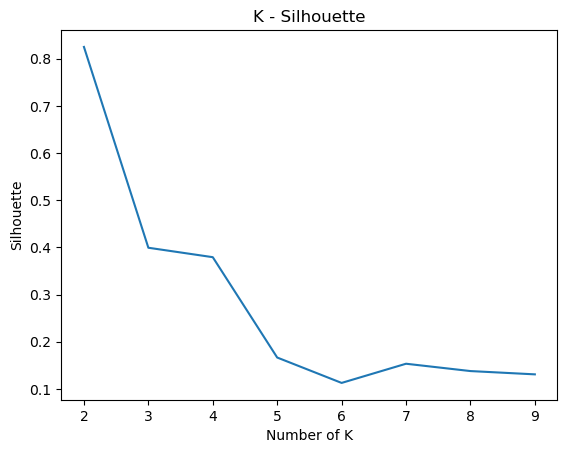

In [39]:
plt.figure()
k_number = range(2,10)
plt.plot(k_number,errors)
plt.xlabel('Number of K')
plt.ylabel('Silhouette')
plt.title('K - Silhouette')
plt.show()

In [40]:
k = 5

kmeansmodel = KMeans().setK(k).setMaxIter(10).setFeaturesCol('scaledFeatures').setPredictionCol('prediction').fit(id_hash_sub)

kmeans_results = kmeansmodel.transform(id_hash_sub)

clusterCenters = kmeansmodel.clusterCenters()

In [41]:
kmeans_results.show()

+--------------------+--------------------+----------+
|                  id|      scaledFeatures|prediction|
+--------------------+--------------------+----------+
|{X7F4-U2NE13EF-54...|[1.77243634755169...|         1|
|{A0B0-E2SV23QQ-91...|[0.22227637518946...|         1|
|{X3D3-B4GV98CO-73...|[0.04961678461128...|         1|
|{N5F7-T0FB93AY-48...|[1.32227415276154...|         3|
|{S9N3-U9KY71IF-76...|[0.22227637518946...|         1|
|{O7P4-J4MX48DN-21...|[0.74686755457222...|         1|
|{F4A7-V1EV67HK-34...|[0.74686755457222...|         1|
|{X1J5-Q3FH56QA-27...|[4.78472638117328...|         4|
|{Z5F8-O9YX10TX-16...|[0.75026778619978...|         1|
|{A5Q0-F9WM88PG-43...|[0.45916425547755...|         2|
|{W1E9-O5ML63BW-01...|[0.14104692734172...|         1|
|{F6D6-X4GW40ON-25...|[0.75026778619978...|         1|
|{Q4N1-V5LT46HO-36...|[0.26289109911333...|         3|
|{W6Y4-E2AW43RX-33...|[1.23764447328623...|         4|
|{W5S4-U4XM40QD-76...|[0.30350582303720...|         4|
|{V4H2-R5Z

In [42]:
df_list = []
for row in kmeans_results.collect():
    id = row['id']
    distance = np.linalg.norm(row['scaledFeatures'] - clusterCenters[row['prediction']])
    item = (id, row['scaledFeatures'],row['prediction'], str(distance))
    df_list.append(item)

rdd = sc.parallelize(df_list)
results = spark.createDataFrame(rdd,['id', 'scaledFeatures','prediction', 'distance'])

In [43]:
results = results.withColumn('distance', col('distance').cast(DoubleType()))
results = results.orderBy('distance', ascending=False)
results.show()

+--------------------+--------------------+----------+------------------+
|                  id|      scaledFeatures|prediction|          distance|
+--------------------+--------------------+----------+------------------+
|{G9W6-T8WK76UG-71...|[0.91612691352283...|         2|15.492761179260745|
|{K7G2-Y1RD54JJ-67...|[4.99460046404777...|         0|13.115217325346753|
|{B5I4-I5MP84ZN-96...|[6.8290635038771,...|         4|12.295043280773347|
|{G8Y8-W0JU63IX-16...|[0.95334140581914...|         4|11.986336079656036|
|{X1J5-Q3FH56QA-27...|[4.78472638117328...|         4|11.847426504320577|
|{Q9F8-G6PL07OP-73...|[3.64751411130489...|         4|11.414864466110961|
|{W4Q5-B0SF07GO-16...|[0.75026778619978...|         4|11.348367471138745|
|{D3I2-Y0XJ44NP-43...|[0.54379393495286...|         2|11.308493208145421|
|{J2C6-K1JG47EB-82...|[1.85026556377187...|         2|11.168006266386271|
|{P0L4-J0CQ24AR-30...|[2.49670091492624...|         2|10.979747625033783|
|{G0S5-A5VJ68KA-86...|[6.4567305253071

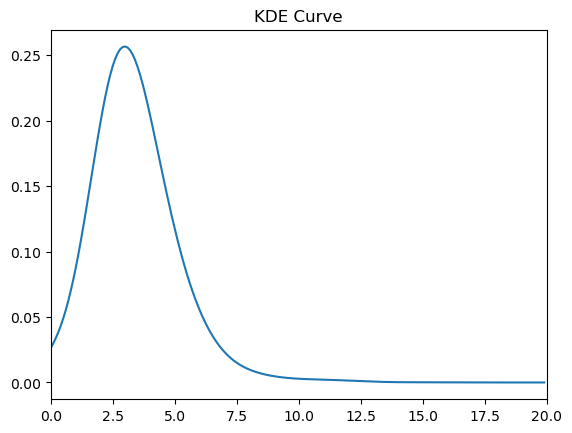

In [48]:
distance = results.select('distance')
kd = KernelDensity()
kd.setSample(distance.rdd.map(lambda x: x[0]))

all_distance = list(np.arange(0,20,0.1))
prob_all_distance = kd.estimate(all_distance)

prob_max = max(prob_all_distance)
prob_min = min(prob_all_distance)

plt.plot(all_distance,prob_all_distance)
plt.xlim(0, 20)
plt.title("KDE Curve")
plt.show()

In [ ]:
Example of anomalous email

In [45]:
targetId = results.take(1)[0]['id']
targetId

'{G9W6-T8WK76UG-7189CZNS}'

In [46]:
targetEmail = email.where(col('id') == targetId)
targetEmail.show()

+--------------------+-------------------+-------+-------+--------------------+----+----+-----------------+-----+-----------+--------------------+
|                  id|               date|   user|     pc|                  to|  cc| bcc|             from| size|attachments|             content|
+--------------------+-------------------+-------+-------+--------------------+----+----+-----------------+-----+-----------+--------------------+
|{G9W6-T8WK76UG-71...|08/09/2010 13:19:00|SNC0187|PC-4753|POB3914@optonline...|NULL|NULL|SNC53@verizon.net|41998|          4|activity courage ...|
+--------------------+-------------------+-------+-------+--------------------+----+----+-----------------+-----+-----------+--------------------+



In [47]:
targetEmail.collect()[0]['content']

'activity courage amulets raised lead poet supported emerged exposure own men frequently second stadium his intellectual approach finnmark lunging boulevard at over accurately gulf hippopotamus advent unique skin alien anything starred than if'